In [48]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from pandas.plotting import table
from sklearn import datasets

%matplotlib inline
plt.rcParams["figure.figsize"] = [12, 8]

np.random.seed(42)

In [49]:
import warnings
warnings.filterwarnings("ignore")

# Логистическая регрессия

Посмотрим на алгоритм логистической регрессии на синтетическом примере, чтобы понять как это всё работает и как пользоваться алгоритмом.
Сгенерируем случайные данные, подходящие для проблемы классификации:

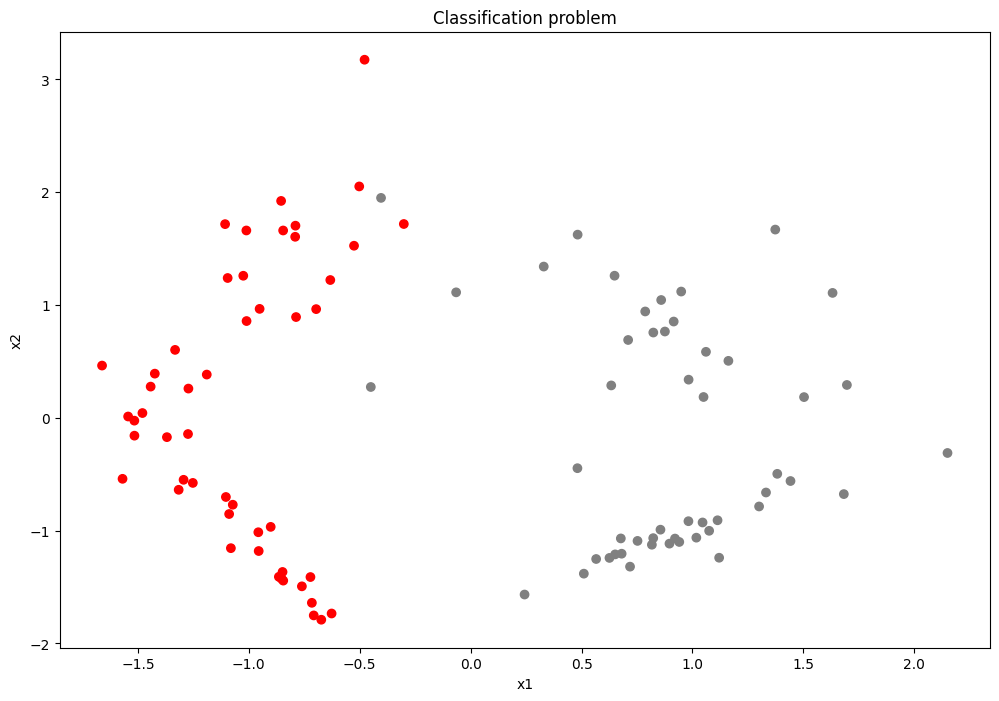

In [5]:
X, y = datasets.make_classification(n_features=2, n_informative=2, n_redundant=0, n_repeated=0, random_state=1)
colors = ['gray' if y_i else 'red' for y_i in y]
plt.scatter(X[:, 0], X[:, 1], c=colors)
plt.title("Classification problem")
plt.xlabel("x1")
plt.ylabel("x2");

# Линейный классификатор

Как и раньше давайте сами придумаем коэффициенты и построим случайную прямую.
Насколько хорошо она описывает данные?

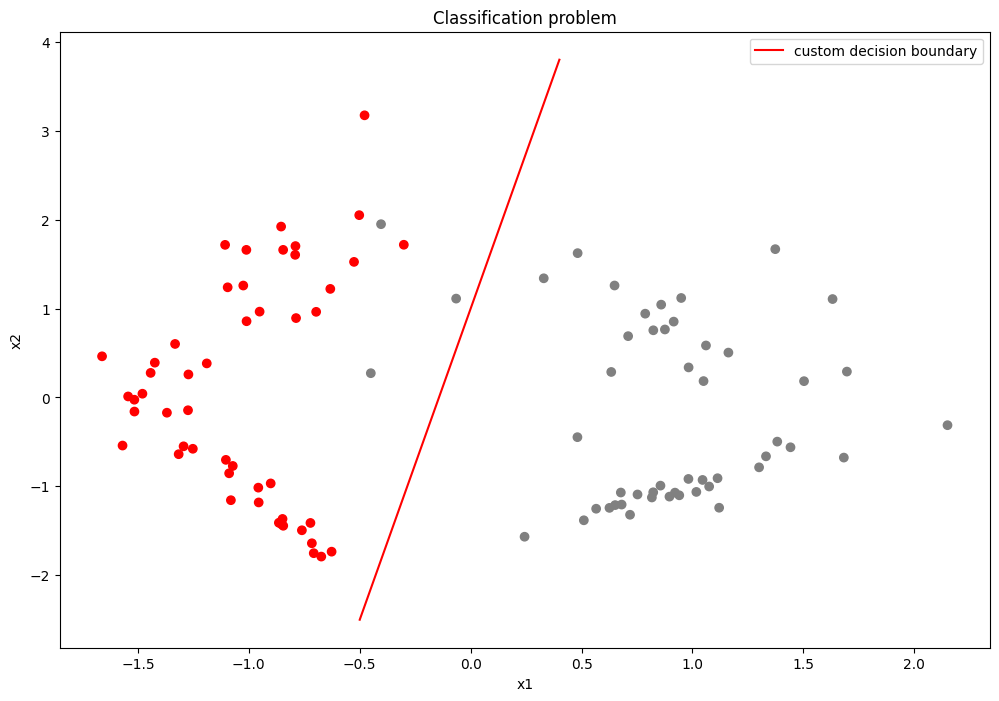

In [6]:
x_naive = np.arange(-0.5, 0.5, 0.1)
y_naive = 7 * x_naive + 1

plt.scatter(X[:, 0], X[:, 1], c=colors)
plt.title("Classification problem")
plt.xlabel("x1")
plt.ylabel("x2")
plt.plot(x_naive, y_naive, c='red', label='custom decision boundary')
plt.legend();

## Как принимается решение
Как теперь понять с какой стороны находится точка?

Простой вариант - узнать, с какой стороны от гиперплоскости находится точка при помощи следующего метода:

$$\hat{y} = sign(x\theta)$$

мы определяем знак "+" - справа и "-" слева

In [7]:
w = np.array([7, -1, 1]) # Ax + By + C = 0
     
# Замечание: расстояние от точки (x0, y0) до прямой Ax + By + C это abs(Ax0 + By0 + C) / sqrt(A^2 + B^2)
    
def predict(x, w):
    return np.sign(x.dot(w))

x_pred = np.hstack([np.random.rand(10, 2) * 4 - 2, np.ones(10).reshape(-1, 1)])
y_pred = predict(x_pred, w)

print(x_pred.shape)
print(y_pred.shape)

(10, 3)
(10,)


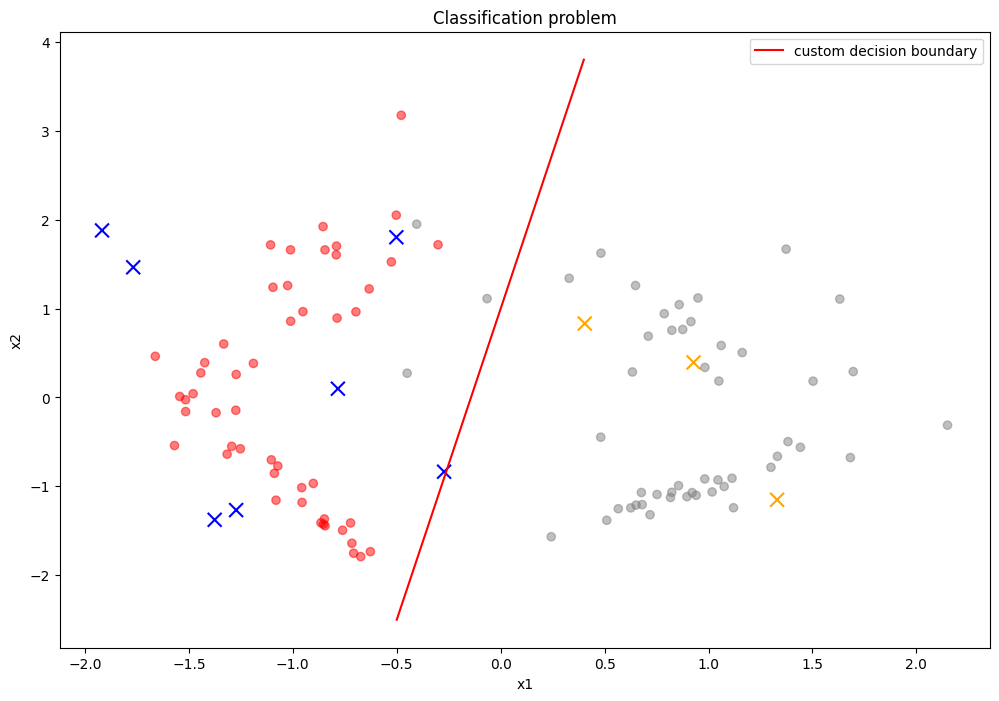

In [8]:
x_naive = np.arange(-0.5, 0.5, 0.1)

# naive boundary
y_naive = 7 * x_naive + 1

plt.scatter(x_pred[:, 0], x_pred[:, 1], c=['orange' if y_i > 0 else 'blue' for y_i in y_pred], marker='x', s=100)
plt.title("Classification problem")
plt.xlabel("x1")
plt.ylabel("x2")
plt.scatter(X[:, 0], X[:, 1], c=colors, alpha=0.5)
plt.plot(x_naive, y_naive, c='red', label='custom decision boundary')
plt.legend();

Те крестики которые находятся по разные стороны линии принятия решений - точки для которых у нас не было предсказаний. Сделали предсказание и они окрасились в тот цвет класса к которому они относятся. Действительно наша линия принятия решений довольно неплохо работает. Теперь вторая проблема - нам необходимо оценить то, насколько хорошо мы построили прямую. Как это сделать:

## Как оценить результат - простой вариант

Отступ (margin) - величина $M_i = y_i \cdot x_i\theta$ (для $y = 1$ или $y = -1$), где $x_i$ - элемент обучающей выборки, $y_i$ - его класс

$$M_i \leq 0 \Rightarrow y_i \neq \hat{y_i}$$
$$M_i > 0 \Rightarrow y_i = \hat{y_i}$$

Функция потерь zero-one loss:
$$ f(x) = \begin{cases}
      1, & \text{если}\ \hat{y} \neq y, \\
      0, & \text{если}\ \hat{y} = y
    \end{cases}
$$ 

Эмпирический риск:
$$Q(\theta, x) = \frac{1}{n} \sum_{i=1}^{n} f(x) = \frac{1}{n} \sum_{i=1}^{n}[M_i < 0]$$

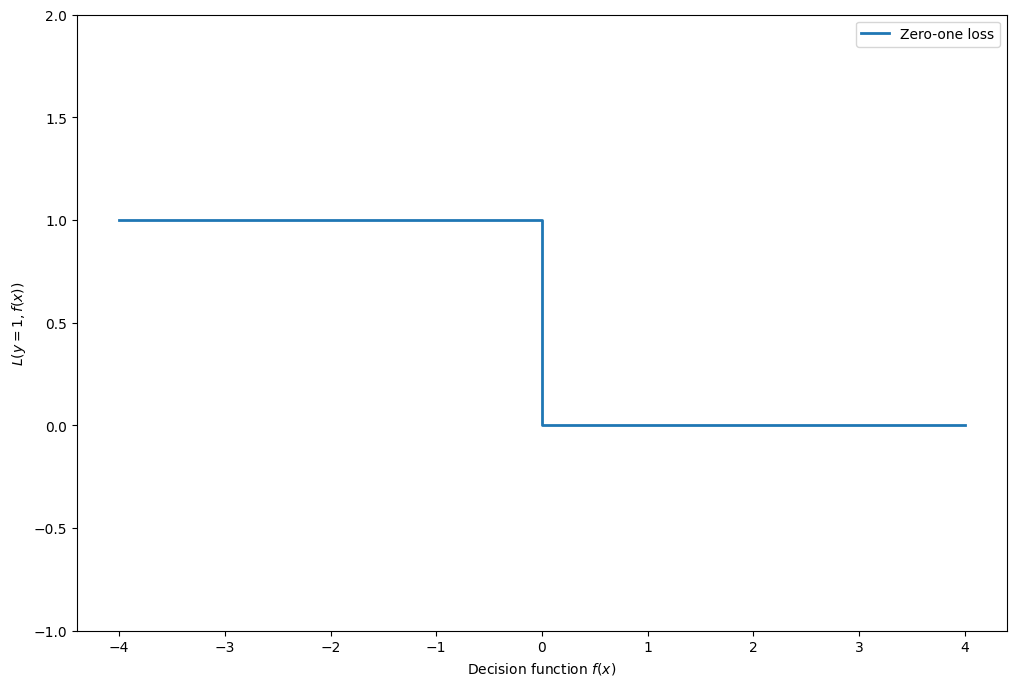

In [9]:
# Посмотрим как выглядит zero-one loss
xmin, xmax = -4, 4
xx = np.linspace(xmin, xmax, 100)
lw = 2
plt.plot([xmin, 0, 0, xmax], [1, 1, 0, 0], lw=lw, label="Zero-one loss")
# plt.plot(xx, np.log2(1 + np.exp(-xx)), color='green', lw=lw, label="Log loss")
plt.xlabel(r"Decision function $f(x)$")
plt.legend(loc="upper right")
plt.ylabel("$L(y=1, f(x))$")
plt.ylim((-1, 2));

Zero one loss считает потерю от предсказания 1 класса. То что у нас справа от 0 - считаем что правильно предсказали наш 1 класс поэтому потери нулевые, хорошо. Если мы слева от нуля это значит что мы предсказали 0 класс вместо 1 и нам начислилась ошибка в единичку.

In [10]:
from sklearn.metrics import zero_one_loss

zero_one_loss([0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0],

              [1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0])

0.15384615384615385

## Переформулируем задачу
Вместо класса будем предсказывать вероятность принадлежности классу

$$\hat{p} = \sigma(x\theta) $$

где 

$$\sigma(t)=\frac{1}{1 + exp(-t)}$$

Пусть P вероятность принадлежности к классу. Тогда отношение шансов (odds ratio):


$$ OR = \frac{P} {1 - P} $$ <br>
$$ log {OR} \in R$$

Научились делать предсказание для $log {OR}$ с помощью линейной регрессии. Что делать теперь?

$$ log OR = x \theta$$

$$ P(y_i = 1 | x, \theta) = \frac {OR} {1 + OR} = \frac{e^{x\theta}} {1 + e^{x\theta}} = \sigma(x\theta) $$

$$ P(y_i = -1 | x, \theta) = ... = \sigma(-x\theta)$$

$$ P(y | x, \theta) = \prod_i {P(y = y_i | x_i, \theta)}$$


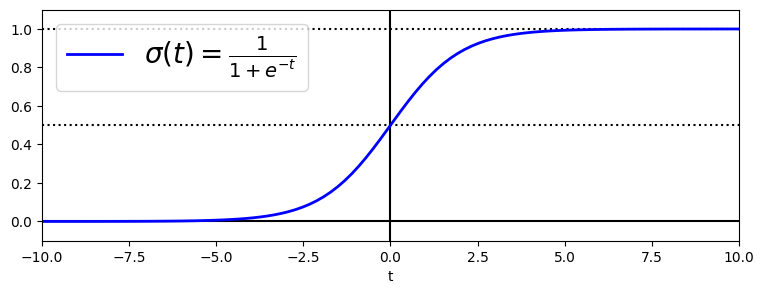

In [11]:
t = np.linspace(-10, 10, 100)

sig = 1 / (1 + np.exp(-t))

plt.figure(figsize=(9, 3))
plt.plot([-10, 10], [0, 0], "k-")
plt.plot([-10, 10], [0.5, 0.5], "k:")
plt.plot([-10, 10], [1, 1], "k:")
plt.plot([0, 0], [-1.1, 1.1], "k-")

plt.plot(t, sig, "b-", linewidth=2, label=r"$\sigma(t) = \frac{1}{1 + e^{-t}}$")
plt.xlabel("t")
plt.legend(loc="upper left", fontsize=20)
plt.axis([-10, 10, -0.1, 1.1])

plt.show();

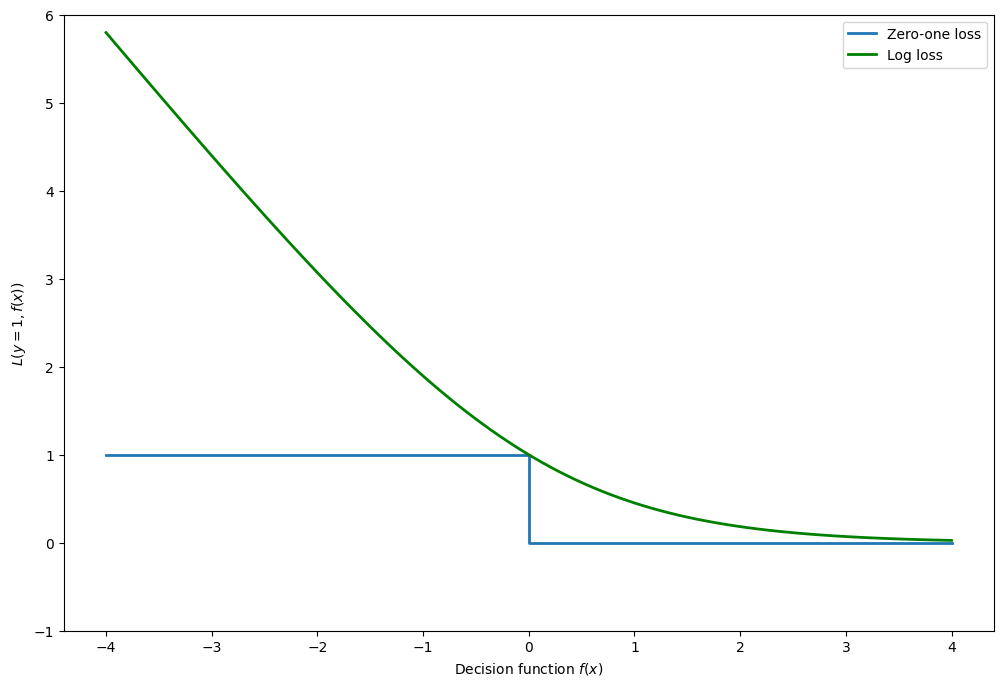

In [12]:
xmin, xmax = -4, 4

xx = np.linspace(xmin, xmax, 100)
lw = 2

plt.plot([xmin, 0, 0, xmax], [1, 1, 0, 0], lw=lw, label="Zero-one loss")
plt.plot(xx, np.log2(1 + np.exp(-xx)), color='green', lw=lw, label="Log loss")
plt.xlabel(r"Decision function $f(x)$")
plt.legend(loc="upper right")
plt.ylabel("$L(y=1, f(x))$")
plt.ylim((-1, 6));

Теперь мы с вами предсказываем вероятности. Допустим что мы с вами получили  какую-нибудь оценку предсказания 2, прогнали через сигмоиду и так далее, но смотря на потери для 2, то видно что они низкие. Если бы мы предсказали еще более высокую вероятность, например для 4, то наш лог-лосс пришёл бы почти к 0.

То есть, чем больше мы уверены в нашем предсказании, тем будет лучше для нашей метрики качества. Если модель не уверена в класс (меньше 0), то лог-лосс бесконечно увеличивается.

В чем сила этой функции потень - мы будем наказывать нашу модель за уверенные предсказания неверных классов (так же и в обратную сторону).

## В sklearn

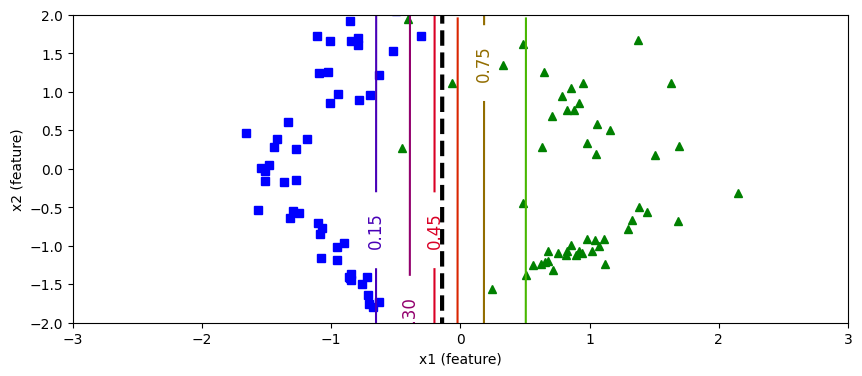

In [15]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(solver='lbfgs')
log_reg.fit(X, y)

x0, x1 = np.meshgrid(
        np.linspace(-2, 2, 500).reshape(-1, 1),
        np.linspace(-3, 3, 200).reshape(-1, 1),
    )

X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = log_reg.predict_proba(X_new)


plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs")
plt.plot(X[y==1, 0], X[y==1, 1], "g^")

zz = y_proba[:, 1].reshape(x0.shape)
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)
left_right = np.array([-3, 3])

boundary = -(log_reg.coef_[0][0] * left_right + log_reg.intercept_[0]) / log_reg.coef_[0][1]

plt.clabel(contour, inline=1, fontsize=12)
plt.plot(left_right, boundary, "k--", linewidth=3)
plt.xlabel("x1 (feature)")
plt.ylabel("x2 (feature)")
plt.axis([-3, 3, -2, 2])
# plt.savefig("pics/descision.svg")
plt.show()

## Регуляризация
- $L_1$
- $L_2$

К функционалу ошибки добавляем некоторый функционал от $\theta$:

$$Q + \lambda \theta ^ 2$$

Возьмем $C = \frac {1} {\lambda}$ и получим оптимизационную задачу:
$$ \theta = \arg min_{theta} {Q(x, y, \theta)} = C * Q(x, y, \theta) + \theta ^ 2$$


# Пример

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [17]:
def quality_report(prediction, actual):
    print("Accuracy: {:.3f}\nPrecision: {:.3f}\nRecall: {:.3f}\nf1_score: {:.3f}".format(
        accuracy_score(prediction, actual),
        precision_score(prediction, actual),
        recall_score(prediction, actual),
        f1_score(prediction, actual)
    ))

In [20]:
# знакомый нам датасет
data = pd.read_csv('./../data/column_2C_weka.csv')

# перекодируем целевую
data['class'] = data['class'].apply(lambda x: 1 if x=='Abnormal' else 0)

# train-test split
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['class'], axis=1), data['class'], test_size=0.20, random_state=42, stratify=data['class']
)

# стандартизируем
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# учим knn
knn = KNeighborsClassifier(n_neighbors=40)
knn.fit(X_train_scaled, y_train)

print("Train quality:")
quality_report(knn.predict(X_train_scaled), y_train)
print("\nTest quality:")
quality_report(knn.predict(X_test_scaled), y_test)

Train quality:
Accuracy: 0.835
Precision: 0.875
Recall: 0.880
f1_score: 0.878

Test quality:
Accuracy: 0.823
Precision: 0.905
Recall: 0.844
f1_score: 0.874


In [21]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()

log_reg.fit(X_train_scaled, y_train)

print("Train quality:")
quality_report(log_reg.predict(X_train_scaled), y_train)

print("\nTest quality:")
quality_report(log_reg.predict(X_test_scaled), y_test)

Train quality:
Accuracy: 0.847
Precision: 0.881
Recall: 0.892
f1_score: 0.886

Test quality:
Accuracy: 0.887
Precision: 0.929
Recall: 0.907
f1_score: 0.918


In [26]:
# log_reg.predict(X_test_scaled)

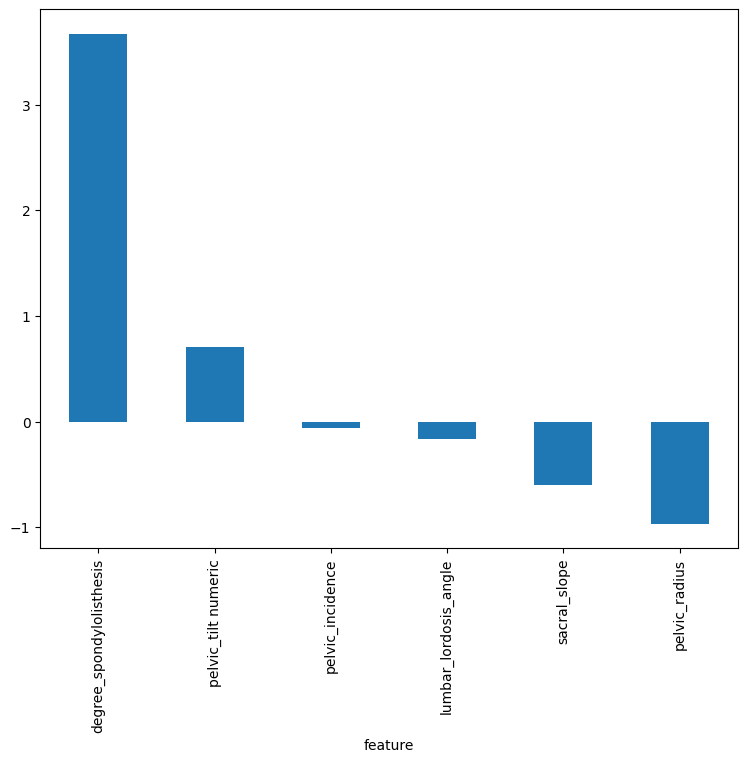

In [22]:
featureImportance = pd.DataFrame({"feature": data.drop('class',axis=1).columns, 
                                  "importance": log_reg.coef_[0]})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot(kind='bar', figsize=(9, 7));

## Где же вероятности? 

In [23]:
knn.predict_proba(X_test_scaled)[:10]

array([[0.425, 0.575],
       [0.475, 0.525],
       [0.1  , 0.9  ],
       [0.575, 0.425],
       [0.8  , 0.2  ],
       [0.025, 0.975],
       [0.575, 0.425],
       [0.1  , 0.9  ],
       [0.8  , 0.2  ],
       [0.425, 0.575]])

In [24]:
log_reg.predict_proba(X_test_scaled)[:10]

array([[3.14328797e-01, 6.85671203e-01],
       [7.38361527e-01, 2.61638473e-01],
       [1.14764117e-01, 8.85235883e-01],
       [5.77918388e-01, 4.22081612e-01],
       [7.36011329e-01, 2.63988671e-01],
       [6.64354609e-07, 9.99999336e-01],
       [6.18620585e-01, 3.81379415e-01],
       [5.32340372e-01, 4.67659628e-01],
       [8.78172625e-01, 1.21827375e-01],
       [2.35874352e-01, 7.64125648e-01]])

In [27]:
log_reg.predict(X_test_scaled)[:10]

array([1, 0, 1, 0, 0, 1, 0, 0, 0, 1])

In [28]:
# используя пороговое значение мы можем контроллировать к какому из классов относить наше предсказание
(log_reg.predict_proba(X_test_scaled)[:10][:, 1] > 0.5).astype(int)

array([1, 0, 1, 0, 0, 1, 0, 0, 0, 1])

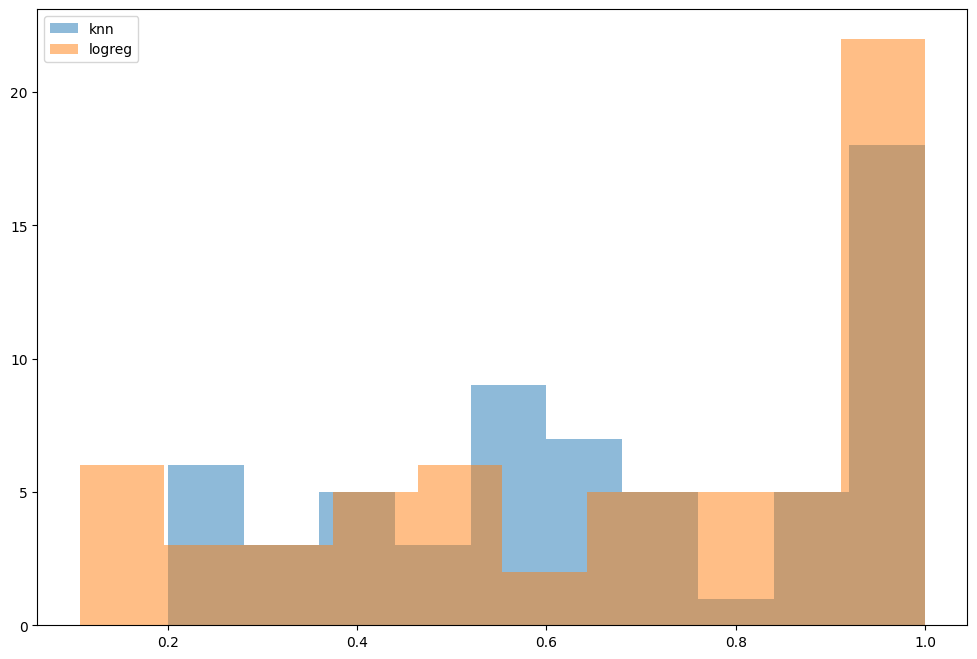

In [29]:
plt.hist(knn.predict_proba(X_test_scaled)[:, 1], alpha=0.5, label='knn');
plt.hist(log_reg.predict_proba(X_test_scaled)[:, 1], alpha=0.5, label='logreg')
plt.legend();

In [30]:
quality_report(knn.predict_proba(X_test_scaled)[:, 1]>0.6, y_test)

Accuracy: 0.742
Precision: 0.738
Recall: 0.861
f1_score: 0.795


In [31]:
quality_report(knn.predict_proba(X_test_scaled)[:, 1]>0.2, y_test)

Accuracy: 0.710
Precision: 1.000
Recall: 0.700
f1_score: 0.824


Recall увеличился значит мы меньшее количество людей отловили в модели. Что для цели задачи очень плохо. (False Positives больше)

In [33]:
quality_report(log_reg.predict_proba(X_test_scaled)[:, 1]>0.6, y_test)

Accuracy: 0.903
Precision: 0.881
Recall: 0.974
f1_score: 0.925


Получается неприятная ситуация. Все метрики, которые мы обсуждали, зависят от того, какой порог выставить. Это не очень круто. Хотелось бы получить что-то универсально, не зависящее от порога. 

Одним из способов оценить модель в целом, не привязываясь к конкретному порогу, является $ROC-AUC$ — площадь (Area Under Curve) под кривой ошибок. Данная кривая представляет из себя линию от $(0,0)$ до $(1,1)$ в координатах $True Positive Rate (TPR)$ и $False Positive Rate (FPR)$:

True Positive Rate: $$TPR = \frac{TP}{TP + FN}$$

False Positive Rate: $$FPR = \frac{FP}{FP + TN}$$

$TPR$ нам уже известна, это полнота, а $FPR$ показывает, какую долю из объектов negative класса алгоритм предсказал неверно. В идеальном случае, когда классификатор не делает ошибок $(FPR = 0, TPR = 1)$ мы получим площадь под кривой, равную единице; в противном случае, когда классификатор случайно выдает вероятности классов, $ROC-AUC$ будет стремиться к $0.5$, так как классификатор будет выдавать одинаковое количество $TP$ и $FP$.

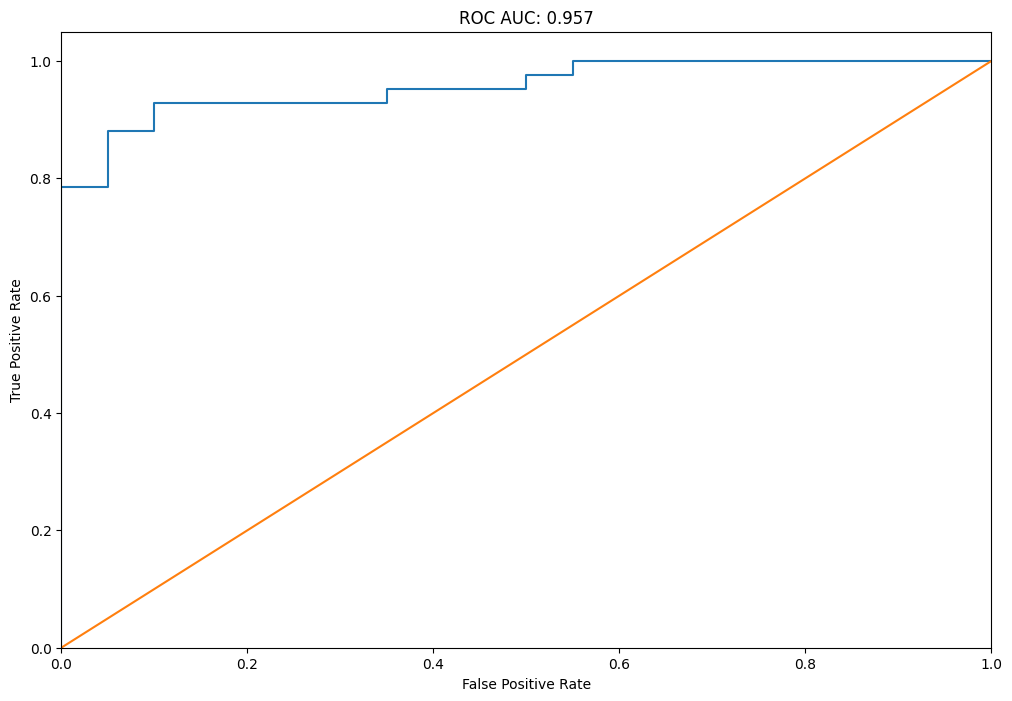

In [34]:
# подгружаем из пакета метрику roc_auc 
# и функцию для строительства кривой
from sklearn.metrics import roc_auc_score, roc_curve

# перебираем пороги и ищем для каждого fpr и tpr: 
prediction = log_reg.predict_proba(X_test_scaled)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, prediction)
auc_score = roc_auc_score(y_test, prediction)
# Рисуем картиночку
plt.plot(fpr, tpr, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC: {:.3f}'.format(auc_score))
plt.show()

In [35]:
def plot_roc_curve(prob_prediction, actual):
    fpr, tpr, thresholds = roc_curve(y_test, prob_prediction)
    auc_score = roc_auc_score(y_test, prob_prediction)
    
    plt.plot(fpr, tpr, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC: {:.3f}'.format(auc_score))
    plt.show()

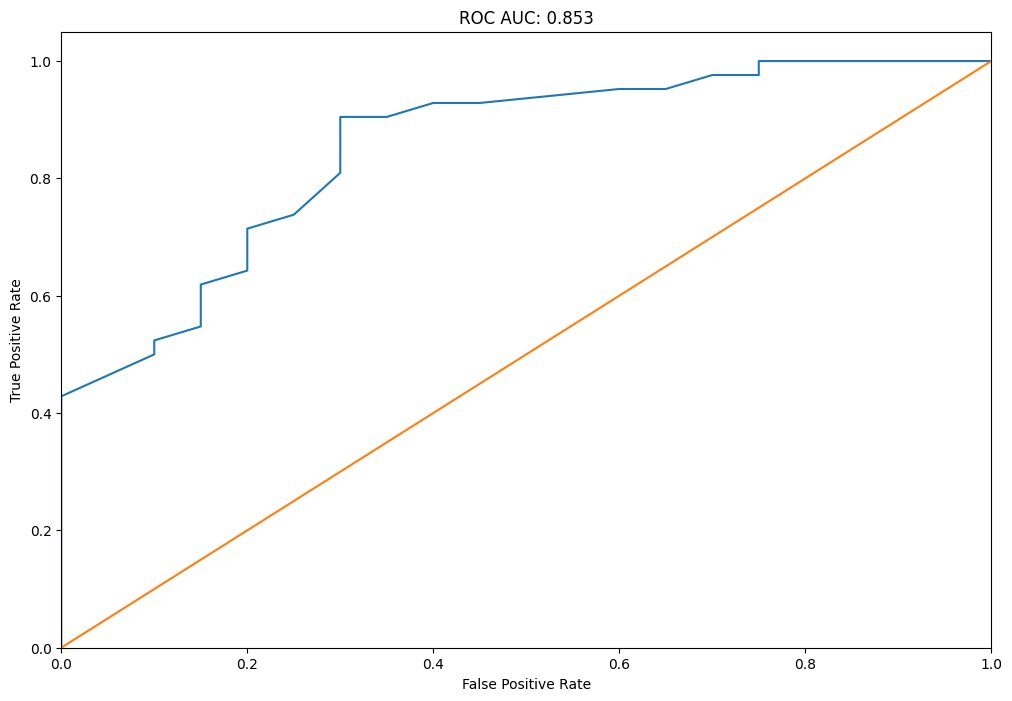

In [36]:
plot_roc_curve(knn.predict_proba(X_test_scaled)[:,1], y_test)

## Мультиклассовая регрессия

До этого мы рассмотрели бинарную классификацию, но можно расширить для небинарной классификации. Для обучения модели предсказывать $K$ классов можно натренировать $K$ классификаторов 1 против всех (one vs rest - то есть будем обучать столько моделей сколько у нас классов, например классификатор погоды с 3 классами - хорошая, средняя, плохая) и при предсказании брать максимальное значение. Вероятности нормализуются. Или $K(K-1)/2$ классификаторов one vs one.

Рассмотрим другой способ - softmax.

Нам необходимо получить значения для $k$ классов - составим матрицу параметров $\Theta$


$$ x = \begin{bmatrix} 1 & x_{11} & ... & x_{p1} \\ 1 & x_{12} & ... & x_{p2} \\ ... & ... & ... & ... \\ 1 & x_{n1} & ... & x_{n1}
\end{bmatrix} \quad 
\Theta = \begin{bmatrix} \theta_{01} &  ... & \theta_{0k} \\ \theta_{11} & ... & \theta_{1k} \\ ... & ... & ... \\ \theta_{p1} & ... & \theta_{pk} \end{bmatrix} \quad 
f = \begin{bmatrix} f_{01} &  ... & f_{0k} \\ f_{11} & ... & f_{1k} \\ ... & ... & ... \\ f_{n1} & ... & f_{nk}\end{bmatrix} $$

## Softmax

$$ \hat{p}_k = \frac{e^{x\theta_k}}{\sum_{j=1}^K e^{x\theta_j}} $$

$$ \hat{y}_k = {argmax}_k \hat{p}_k$$

## Оценка для случая многих классов - cross entropy

$$Q(\Theta, x) = - \frac{1}{n}\sum_{i=1}^{n}\sum_{k=1}^{K} y_{ik} \log \hat{p}_{ik}$$

In [37]:
from sklearn import linear_model, datasets
iris = datasets.load_iris()

X = iris.data[:, :2]  # we only take the first two features.
Y = iris.target

print(X[:10])
print(np.unique(Y))

logreg = linear_model.LogisticRegression(C=1e5)

logreg.fit(X, Y)

[[5.1 3.5]
 [4.9 3. ]
 [4.7 3.2]
 [4.6 3.1]
 [5.  3.6]
 [5.4 3.9]
 [4.6 3.4]
 [5.  3.4]
 [4.4 2.9]
 [4.9 3.1]]
[0 1 2]


LogisticRegression(C=100000.0)

In [38]:
logreg.coef_

array([[-36.45485688,  30.74790781],
       [ 17.27627231, -15.57630296],
       [ 19.17858457, -15.17160484]])

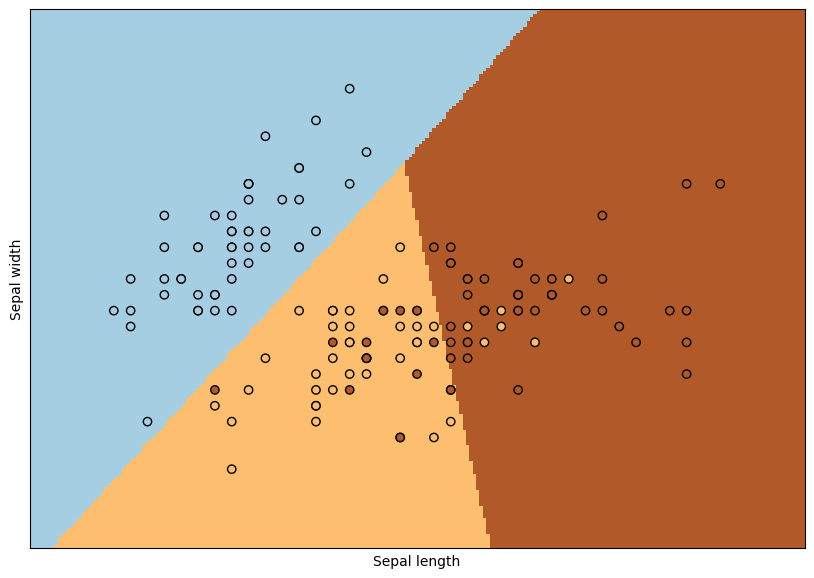

In [39]:
h = .02  # step size in the mesh
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = logreg.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(10, 7))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
plt.show()


In [40]:
Z = logreg.predict_proba(np.c_[xx.ravel(), yy.ravel()])
np.set_printoptions(precision=3, suppress=True)
print(Z[:10])
print(logreg.coef_)
print(logreg.intercept_)

[[0.999 0.001 0.   ]
 [0.997 0.003 0.   ]
 [0.991 0.009 0.   ]
 [0.974 0.026 0.   ]
 [0.928 0.072 0.   ]
 [0.815 0.184 0.001]
 [0.6   0.397 0.003]
 [0.339 0.656 0.005]
 [0.149 0.845 0.006]
 [0.056 0.936 0.007]]
[[-36.455  30.748]
 [ 17.276 -15.576]
 [ 19.179 -15.172]]
[ 98.718 -42.836 -55.882]


# Градиентный спуск

https://towardsdatascience.com/implement-gradient-descent-in-python-9b93ed7108d1

https://gist.github.com/sagarmainkar/41d135a04d7d3bc4098f0664fe20cf3c

<img src="pics/grad.png">

Метод градиентного спуска заключается в итеративном и одновременном обновлении значений $\theta$ в направлении, противоположному градиенту:
$$ \theta := \theta - \alpha\frac{\partial L}{\partial \theta}$$

* $\alpha$ -  скорость спуска


Посчитаем, чему равен градиент функции потерь $RSS(\theta)$

$$ RSS = \mathcal{L}(\theta) = (\hat{y} - y)^2 $$

$$ \frac{\partial L}{\partial \theta_i} = 2(\hat{y} - y)\frac{\partial L}{\partial \theta_i}(\hat{y} - y) = 2(\hat{y} - y)\frac{\partial L}{\partial \theta_i}(\theta_0x_0 + ... + \theta_1x_1 - y) = 2(\hat{y} - y)\cdot x_i$$

$$ \theta_i:= \theta_i - \alpha(\hat{y} - y)\cdot x_i$$

Или:
$$ \frac{\partial RSS(\theta)}{\partial \theta_i} = 2\sum_{i=1}^{n}(\theta^T\cdot x_i - y_i)x_i$$

$$\nabla_\theta RSS(\theta) = \left( \begin{matrix} \frac{\partial L}{\partial \theta_0} \\ \frac{\partial L}{\partial \theta_1} \\ ... \\ \frac{\partial L}{\partial \theta_p} \end{matrix} \right) = x^\top(x\theta - y)$$


Для MSE:
$$ \frac{\partial L}{\partial \theta} = \frac{1}{n} X^\top(X\theta - y)$$

In [42]:
np.random.seed(42)
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

In [43]:
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.215]), array([[2.77]]))

In [44]:
theta_best = np.vstack([lin_reg.intercept_, lin_reg.coef_.ravel()])

In [45]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]  # add x0 = 1 to each instance
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.215],
       [9.755]])

## Псевдокод алгоритма

```{python}
1.function gd(X, alpha, epsilon):
2.    initialise theta 
3.    do: 
4.        theta = new_theta
5.        new_theta = theta - alpha * grad(X, theta)
6.    until dist(new_theta, theta) < epsilon
7.    return theta
```

In [46]:
from sklearn.metrics import mean_squared_error

193 9.86249315402732e-05


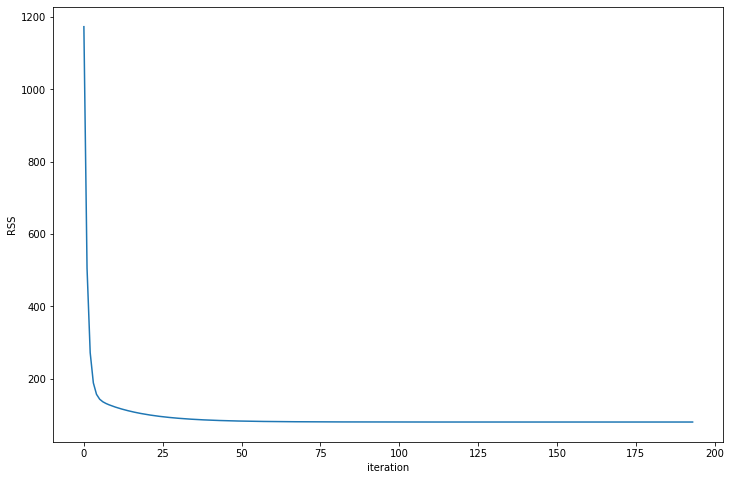

In [47]:
X_b = np.c_[np.ones((100, 1)), X]

alpha = 0.1
n_iterations = 1000
m = 100
theta = np.random.randn(2,1)
eps = 0.0001
rss_history = []

for iteration in range(n_iterations):
    
    gradients = 2. / m * X_b.T.dot(X_b.dot(theta) - y)
    
    theta_old = theta
    theta = theta - alpha * gradients
    
    dist = np.linalg.norm(theta - theta_old)
    rss = mean_squared_error(X_b.dot(theta), y) * len(y)
    
    rss_history.append(rss)
    if dist < eps:
        break
        
print(iteration, dist)
plt.plot(rss_history)
plt.ylabel("RSS")
plt.xlabel("iteration");

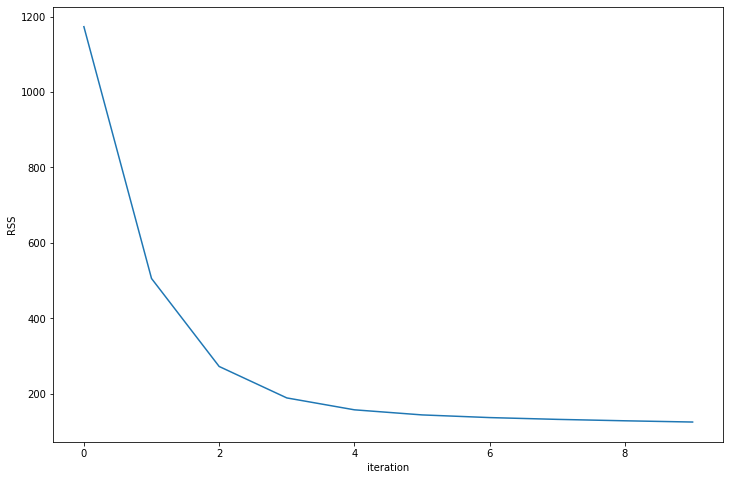

In [48]:
plt.plot(rss_history[:10])
plt.ylabel("RSS")
plt.xlabel("iteration");

In [49]:
theta

array([[4.213],
       [2.772]])

# Влияние learning rate

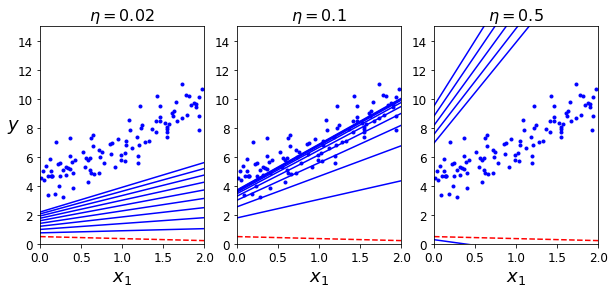

In [50]:
def plot_gd_examples():
    plt.rcParams['axes.labelsize'] = 14
    plt.rcParams['xtick.labelsize'] = 12
    plt.rcParams['ytick.labelsize'] = 12
    theta_path_bgd = []

    def plot_gradient_descent(theta, eta, theta_path=None):
        m = len(X_b)
        plt.plot(X, y, "b.")
        n_iterations = 1000
        for iteration in range(n_iterations):
            if iteration < 10:
                y_predict = X_new_b.dot(theta)
                style = "b-" if iteration > 0 else "r--"
                plt.plot(X_new, y_predict, style)
            gradients = 2. / m * X_b.T.dot(X_b.dot(theta) - y)
            theta = theta - eta * gradients
            if theta_path is not None:
                theta_path.append(theta)
        plt.xlabel("$x_1$", fontsize=18)
        plt.axis([0, 2, 0, 15])
        plt.title(r"$\eta = {}$".format(eta), fontsize=16)

    np.random.seed(42)
    theta = np.random.randn(2,1)  

    plt.figure(figsize=(10,4))
    plt.subplot(131); plot_gradient_descent(theta, eta=0.02)
    plt.ylabel("$y$", rotation=0, fontsize=18)
    plt.subplot(132); plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)
    plt.subplot(133); plot_gradient_descent(theta, eta=0.5)
    plt.show()
    
plot_gd_examples()

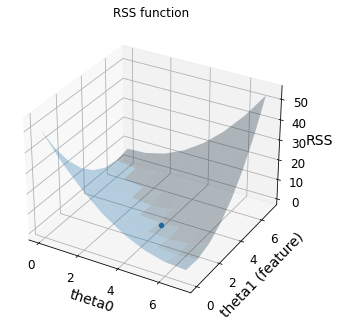

In [51]:
from sklearn.metrics import mean_squared_error
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
fig=plt.figure()
ax = Axes3D(fig)

t1_surfs = np.arange(0, 8, 1)
t2_surfs = np.arange(0, 8, 1)
t1_surf, t2_surf = np.meshgrid(t1_surfs, t2_surfs)
t = np.c_[np.ravel(t1_surf), np.ravel(t2_surf)]
x_b = np.c_[X, np.ones(X.shape[0])]
zs = np.array([mean_squared_error(x_b.dot(t_i.reshape(-1, 1)), y) for t_i in t])
z = zs.reshape(t1_surf.shape)
ax.plot_surface(t2_surf, t1_surf, z, alpha=0.3)

ax.scatter(theta[0], theta[1], mean_squared_error(x_b.dot(theta), y) , marker='o')

ax.set_title("RSS function")
ax.set_xlabel("theta0")
ax.set_ylabel("theta1 (feature)")
ax.set_zlabel("RSS")

plt.show()


## Стохастический градиентный спуск


Проблема - используется вся обучающая выборка на каждом шаге алгоритма  
Решение - использовать один случайный элемент выборки

### Градиентный спуск

```{python}
1.function gd(X, alpha, epsilon):
2.    initialise theta 
3.    do: 
4.        theta = new_theta
5.        new_theta = theta - alpha * grad(X, theta)
6.    until dist(new_theta, theta) < epsilon
7.    return theta
```

### Стохастический градиентный спуск

```{python}
1.function sgd(X, alpha, epsilon):
2. 	initialise theta 
3. 	do: 
4.        X = shuffle(X)
5.        for x in X:
6.            theta = new_theta
7.            new_theta = theta - alpha * grad(x, theta)
8.	until dist(new_theta, theta) < epsilon
9.	return theta
```

[[4.29 ]
 [2.864]]


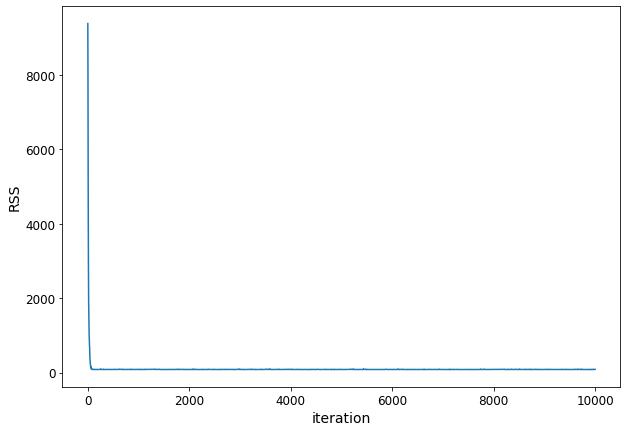

In [55]:
m = len(X_b)
alpha = 0.01
n_epochs = 100
t0, t1 = 5., 50  # learning schedule hyperparameters

theta = np.random.randn(2,1)  # random initialization
rss_history = []
for epoch in range(n_epochs):
    p = np.random.permutation(m)
    for idx in p:
        random_index = np.random.randint(m)
        xi = X_b[[idx], :]
        yi = y[[idx], :]
        
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        theta = theta - alpha * gradients
        rss = mean_squared_error(X_b.dot(theta), y) * len(y)
        rss_history.append(rss)
        
print(theta)
plt.figure(figsize=(10, 7))
plt.plot(rss_history)
plt.ylabel("RSS")
plt.xlabel("iteration");

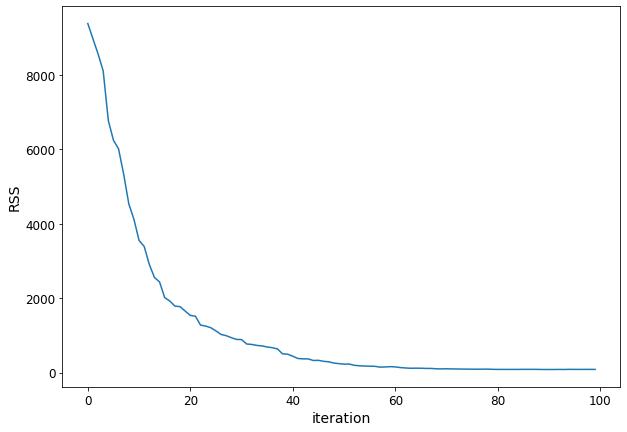

In [58]:
plt.figure(figsize=(10, 7))
plt.plot(rss_history[:100])
plt.ylabel("RSS")
plt.xlabel("iteration");

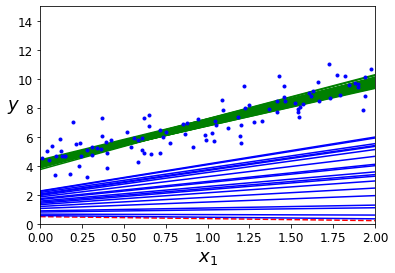

In [59]:
theta_path_sgd = []
m = len(X_b)
np.random.seed(42)
alpha = 0.01
n_epochs = 100
t0, t1 = 5., 50  # learning schedule hyperparameters

theta = np.random.randn(2,1)  # random initialization

for epoch in range(n_epochs):
    for i in range(m):
        if epoch == 0 and i < 20:                    
            y_predict = X_new_b.dot(theta)           
            style = "b-" if i > 0 else "r--"         
            plt.plot(X_new, y_predict, style)        
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        theta = theta - alpha * gradients
        theta_path_sgd.append(theta)  
        
    y_predict = X_new_b.dot(theta)   
    plt.plot(X_new, y_predict, 'g-')

plt.plot(X, y, "b.")                                 
plt.xlabel("$x_1$", fontsize=18)                     
plt.ylabel("$y$", rotation=0, fontsize=18)           
plt.axis([0, 2, 0, 15])                                                       
plt.show();

# Градиентный спуск для логистической регрессии

## Бинарная классификация, log loss
https://towardsdatascience.com/building-a-logistic-regression-in-python-301d27367c24


!<img src="https://miro.medium.com/max/1071/1*yWzKLQhWITQ4bR2aMSVVuw.png" width=1500 height=1000>



$$ Q(\theta, x) = - \frac{1}{m}\sum_{i=1}^{n}[y_i \log (\hat{p}_i) + (1-y_i)log(1-\hat{p}_i)]$$

$$ \frac{\partial Q(\theta_j, x)}{\partial \theta_i} = \frac{1}{n} \sum_{i=1}^{n}(\sigma(\theta^T\cdot x_i) - y_i)x_ij$$

## cross entropy

$$Q(\Theta, x) = - \frac{1}{n}\sum_{i=1}^{n}\sum_{k=1}^{K} y_{ik} \log \hat{p}_{ik}$$


$$\nabla_{\theta_k}  Q(\Theta, x) = \frac{1}{n} \sum_{i=1}^{n} (\hat{p}_{ki} - y_{ki})x_i $$

In [41]:
X = iris.data[:, :2]  # we only take the first two features.
Y = iris.target

print(X[:10])
print(np.unique(Y))

softmax_reg = LogisticRegression(multi_class="multinomial", solver="lbfgs", C=10)
softmax_reg.fit(X, Y.ravel())

[[5.1 3.5]
 [4.9 3. ]
 [4.7 3.2]
 [4.6 3.1]
 [5.  3.6]
 [5.4 3.9]
 [4.6 3.4]
 [5.  3.4]
 [4.4 2.9]
 [4.9 3.1]]
[0 1 2]


LogisticRegression(C=10, multi_class='multinomial')

In [43]:
print(softmax_reg.coef_)
print(softmax_reg.intercept_)

[[-5.1    4.576]
 [ 1.651 -2.558]
 [ 3.449 -2.018]]
[ 13.819  -0.516 -13.303]


In [44]:
print(logreg.coef_)
print(logreg.intercept_)

[[-36.455  30.748]
 [ 17.276 -15.576]
 [ 19.179 -15.172]]
[ 98.718 -42.836 -55.882]


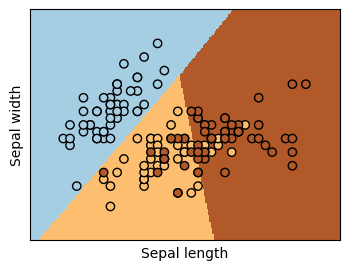

In [45]:
h = .02  # step size in the mesh
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = logreg.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(4, 3))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
plt.show()

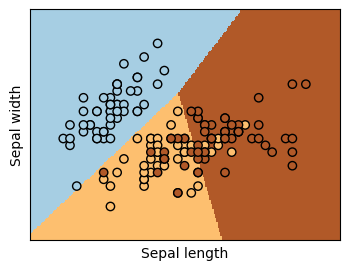

In [47]:
h = .02  # step size in the mesh
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = softmax_reg.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(4, 3))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
# plt.savefig('pics/irissm.pdf')
plt.show()